> <p><small><small>This Notebook is made available subject to the licence and terms set out in the <a href = "http://www.github.com/google-deepmind/ai-foundations">AI Research Foundations Github README file</a>.

![](https://storage.googleapis.com/dm-educational/assets/ai_foundations/GDM-Labs-banner-image-C4-white-bg.png)

# Lab: Implement Masked Multi-Head Attention

<a href='https://colab.research.google.com/github/google-deepmind/ai-foundations/blob/master/course_4/gdm_lab_4_3_implement_attention_equation_2.ipynb' target='_parent'><img src='https://colab.research.google.com/assets/colab-badge.svg' alt='Open In Colab'/></a>

Compute the attention weight vector for multiple heads and apply masking to prevent the model from "looking into the future."

25 minutes

## Overview

In this lab, you will implement **masked multi-head attention**. As in the previous lab, you will use the learned projection matrices $W_Q$, $W_K$, $W_V$ from the Gemma-1B model and use these three matrices to compute the attention weights and the output of the attention mechanism.

To simplify things, the previous two labs only considered the first attention head of the Gemma-1B model. In this lab, you can also visualize the other attention heads. In the case of Gemma-1B, there are four attention heads per layer.

### What you will learn

By the end of this lab, you will:

* Understand how you can compute the attention weights for multiple heads in parallel.
* Recognize the role of masking attention weights in producing the final attention output.

### Tasks

In this lab, you will:

* Implement a function to create an attention mask.
* Implement the masked multi-head attention mechanism.
* Visualize and compare your attention weights with the attention weights of the reference implementation.


## How to use Google Colaboratory (Colab)

Google Colaboratory (also known as Google Colab) is a platform that allows you to run Python code in your browser. The code is written in **cells** that are executed on a remote server.

To run a cell, hover over the cell and click on the `run` button to its left. The run button is the circle with the triangle (▶). Alternatively, you can also click on a cell and use the keyboard combination Ctrl+Return (or ⌘+Return if you are using a Mac).

To try this out, run the following cell. This should print today's day of the week below it.

In [ ]:
from datetime import datetime

print(f"Today is {datetime.today():%A}.")

Note that the *order in which you run the cells matters*. When you are working through a lab, make sure to always run *all* cells in order, otherwise the code might not work. If you take a break while working on a lab, Colab may disconnect you and in that case, you have to execute all cells again before  continuing your work. To make this easier, you can select the cell you are currently working on and then choose __Runtime → Run before__  from the menu above (or use the keyboard combination Ctrl/⌘ + F8). This will re-execute all cells before the current one.

## Imports

In this lab, you will mainly work with the JAX package to modify vectors and matrices. You will also use functions from the custom `ai_foundations` package to load Gemma, extract its parameters and to generate visualizations.

Run the following cell to import the required packages.

In [1]:
%%capture
# Install the custom package for this course.
!pip install orbax-checkpoint==0.11.21
!pip install "git+https://github.com/google-deepmind/ai-foundations.git@main"

import jax # For working with vectors and matrices.
import jax.numpy as jnp # For working with vectors and matrices.
from ai_foundations import generation # For prompting the Gemma model.
from ai_foundations import visualizations # For visualizing attention weights.
from ai_foundations import attention # For working with Q,K,V matrices.
# For providing feedback on your implementation.
from ai_foundations.feedback.course_4 import attention as attention_feedback

## Load the model and visualize attention weights

You will use the parameters from the Gemma-1B model to compute the attention weights.

Run the following cell to load the Gemma-1B parameters and initialize the caches.

In [2]:
# Initialize caches for prompts.
previous_prompt = None
previous_prompt2 = None

# Load special version of the Gemma-1B model that provides access to attention
# weights and QKV matrices.
print("Loading Gemma-1B...")
model = generation.load_gemma("Gemma-1B-AttentionWeight")
print("Loaded Gemma-1B.")

Loading Gemma-1B...
Loaded Gemma-1B.


As in the previous labs, the following cell allows you to visualize the Gemma attention weights. Now you can also set which head should be considered. You can again use this cell as a reference and compare your own implementation to the output of the reference implementation. This will ensure that you have implemented everything accurately.

Make sure to run this cell for at least one prompt as it also extracts the query, key, and value matrices that you will use in other cells.

Generated text: Jide was hungry so she went looking for food


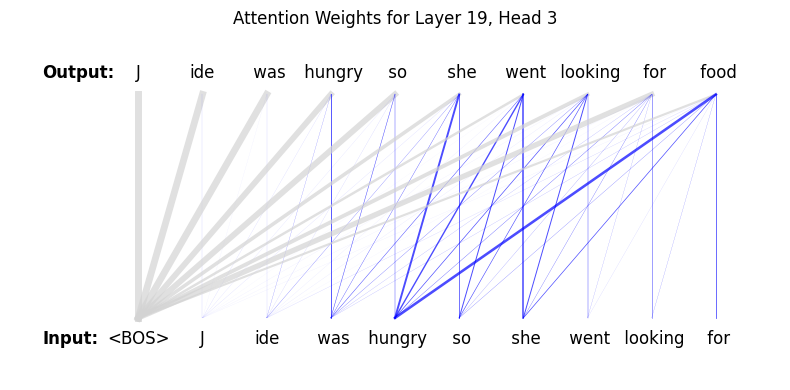

In [3]:
# @title Visualize attention weights (reference implementation)
from IPython.display import clear_output

layer = 19  # @param {type:"slider", min: 0, max: 25}

head = 3  # @param {type:"slider", min: 0, max: 3}

prompt = "Jide was hungry so she went looking for"  # @param {type: "string"}
# @markdown Check the following box to display the attention weights for all tokens, not just for the generated one:
show_all_weights = True  # @param {type:"boolean"}

if prompt != previous_prompt:
    (
        output_text,
        next_token_logits,
        tokenizer,
        attention_weights,
        _,
        qkv_dict,
    ) = generation.prompt_attention_transformer_model(
        prompt, model, sampling_mode="greedy"
    )
    tokens = [tokenizer.tokens[t] for t in tokenizer.encode(output_text)]
    previous_prompt = prompt

print(f"Generated text: {output_text}")

visualizations.visualize_attention(
    tokens,
    attention_weights[f"layer_{layer}"],
    layer,
    head=head,
    min_line_thickness=0,
    max_line_thickness=5,
    show_all_weights=show_all_weights,
)

## Coding Activity 1: Attention mask

------
>**💻 Your task:**
>
>Complete the implementation of `compute_attention_mask` for computing the attention mask. The attention mask is a square triangular matrix where every value on or below the diagonal is 1 and every value above the diagonal is 0. Consider using [`jnp.tri`](https://docs.jax.dev/en/latest/_autosummary/jax.numpy.tri.html) for generating this matrix.
>
>Once you are done, run the following two cells to test your implementation. It should print the attention masks for inputs of lengths 5 and 6.
>
------



In [4]:
def compute_attention_mask(num_tokens: int) -> jax.Array:
    """Computes the attention mask for an input of length `num_tokens`.

    Args:
      num_tokens: Number of tokens in the input.

    Returns:
      attention_mask: A diagonal matrix indicating which attention logit should
        be masked. Shape: (num_tokens, num_tokens).
    """

    attention_mask = jnp.tri(num_tokens)  # Compute the attention mask here.

    return attention_mask

print(f"Attention mask for input length 5:\n {compute_attention_mask(5)}")
print(f"\nAttention mask for input length 6:\n {compute_attention_mask(6)}")

Attention mask for input length 5:
 [[1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1.]]

Attention mask for input length 6:
 [[1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1.]]


In [5]:
# @title Run this cell to test your implementation of `compute_attention_mask`.
attention_feedback.test_compute_attention_mask(compute_attention_mask)

✅ All tests passed. Your implementation is looking good.


## Implement multi-head attention

During the next five activities, you will now implement the multi-head attention mechanism step-by-step.

### Coding Activity 2: Stack matrices

------
>**💻 Your task:**
>
> As a first step, you will prepare the query, key, and value projections such that you can easily compute the attention weights for all heads in parallel. To do this, complete the `stack_matrices` function in the following cell.
>
> The query, key, and value projections are stored in a list where each list entry is one projection matrix for one head (e.g., the first list entry in all three lists corresponds to the $Q$, $K$, and $V$ matrices for the first attention head). `stack_matrices` should stack these matrices together such that you obtain a 3-dimensional tensor (i.e., a matrix but with 3 dimensions) for $Q$, $K$, and $V$. The first dimension should correspond to the head, the second dimension to the token index, and the third dimension should be individual components of the vectors. Consider using the [`jnp.stack`](https://docs.jax.dev/en/latest/_autosummary/jax.numpy.stack.html) function for stacking matrices.
>
> Complete the implementation in the next cell and test your implementation by running the cell after that.
------


In [8]:
def stack_matrices(
    qkv_dict: dict[str, dict[str, jax.Array]], layer: int
) -> tuple[jax.Array, jax.Array, jax.Array]:
    """Retrieves the list of query, key, and value matrices for each head and
        stacks them into a multi-dimensional tensor.

    Args:
      qkv_dict: A dictionary containing the raw query, key, and value
        projections for all layers. The keys are strings identifying the layers
        and matrix types, and values are the corresponding JAX arrays.
      layer: The specific layer for which to compute the attention weights.

    Returns:
      query_proj: Query projection tensor.
        Shape: (num_heads, num_tokens, dim_k).
      key_proj: Key projection tensor. Shape: (num_heads, num_tokens, dim_k).
      value_proj: Value projection tensor.
        Shape: (num_heads, num_tokens, dim_v).
    """

    # Passing `head=None` results in `get_qkv_matrices` returning lists of
    # `num_heads` projection matrices rather than just an individual projection
    # matrix.
    (
        query_proj_list,
        key_proj_list,
        value_proj_list
    ) = attention.get_qkv_matrices(
        qkv_dict, layer, head=None
    )

    # Stack the query, key, and value projection matrices here:
    query_proj = jnp.stack(query_proj_list,axis=0)
    key_proj = jnp.stack(key_proj_list,axis=0)
    value_proj = jnp.stack(value_proj_list,axis=0)

    return query_proj, key_proj, value_proj

In [9]:
# @title Run this cell to test your implementation of `stack_matrices`.
attention_feedback.test_stack_matrices(stack_matrices, qkv_dict)

✅ All tests passed. Your implementation is looking good.


### Coding Activity 3: Compute raw logits

------
> **💻 Your task:**
>
> As the next step, complete the function `compute_raw_logits` to compute the logits using the query and key matrix.
>
> This function needs to implement three operations:
> 1. Compute $d_k$, the dimension of the key vectors which you need to compute the normalization factor. Remember that you can use [`.shape`](https://docs.jax.dev/en/latest/_autosummary/jax.Array.shape.html) for this.
> 2. Compute the transposition of the key projection matrix, $K^T$. This is already implemented.
> 3. Compute the logits. You get these from performing a matrix multiplication between the query projections and the key projections and then normalizing them by the square root of $d_k$:
>
>$$\mbox{logits} = \frac{QK^T}{\sqrt{d_k}}$$
>
> Complete the implementation in the next cell and test your implementation by running the cell after that.
>
------

In [10]:
def compute_raw_logits(query_proj: jax.Array, key_proj: jax.Array) -> jax.Array:
    """Computes the raw logits from the query and key projection tensors, before
    applying the attention mask.

    Args:
      query_proj: The query projection tensor.
        Shape: (num_heads, num_tokens, dim_k).
      key_proj: The key projection tensor.
        Shape: (num_heads, num_tokens, dim_k).

    Returns:
      logits: The raw logits. Shape: (num_heads, num_tokens, num_tokens).
    """

    # Transpose the last two dimensions of the key matrix for matrix
    # multiplication. The shape changes from (num_heads, num_tokens, dim_k) to
    # (num_heads, dim_k, num_tokens).
    key_transposed = jnp.transpose(key_proj, (0, 2, 1))

    logits =  query_proj @ key_transposed / jnp.sqrt(query_proj.shape[2])

    return logits

In [11]:
# @title Run this cell to test your implementation of `compute_raw_logits`.
attention_feedback.test_compute_raw_logits(compute_raw_logits, qkv_dict)

✅ All tests passed. Your implementation is looking good.


### Coding Activity 4: Apply attention mask

------
> **💻 Your task:**
>
> Complete the function `apply_attention_mask` to compute the attention mask and apply it to the raw logits from the previous step.
>
> This function needs to implement two operations:
> 1. Compute the attention mask using your `compute_attention_mask` function.
> 2. Compute the masked logits:
>   $$\mbox{logits_masked}_{i,j} = \begin{cases}\mbox{logits}_{i,j} & \mbox{if mask}_{i,j} = 1 \\ K & \mbox{otherwise}\end{cases}$$
>   To compute a function that depends on a condition like this, you can use the [`jnp.where`](https://docs.jax.dev/en/latest/_autosummary/jax.numpy.where.html) function. $K$ is defined in the next cell as `K_MASK`.
>
>
> Complete the implementation in the next cell and test your implementation by running the cell after that.
>
------


In [13]:
K_MASK = -2.3819763e+38

def apply_attention_mask(logits_raw: jax.Array) -> jax.Array:
    """Computes the attention mask (using `compute_attention_mask`) and
    applies it to the logits.

    Args:
      logits_raw: Raw logits. Shape: (num_heads, num_tokens, num_tokens).

    Returns:
      Masked logits. Shape: (num_heads, num_tokens, num_tokens).
    """

    _, num_tokens, _ = logits_raw.shape

    attention_mask = compute_attention_mask(num_tokens) # Compute the attention mask here.
    logits_masked =  jnp.where(attention_mask,logits_raw,K_MASK)# Compute the masked logits here.

    return logits_masked

In [14]:
# @title Run this cell to test your implementation of `apply_attention_mask`.
attention_feedback.test_apply_attention_mask(apply_attention_mask, qkv_dict)

✅ All tests passed. Your implementation is looking good.


### Coding Activity 5: Compute attention weights

------
> **💻 Your task:**
>
> Complete the function `compute_attention_weights` to compute the attention weights `alpha`.
>
> `alpha` is computed by applying the SoftMax function to the logits. You can either implement your own SoftMax function or use [`jax.nn.softmax`](https://docs.jax.dev/en/latest/_autosummary/jax.nn.softmax.html):
$$\alpha = \mbox{SoftMax}(\mbox{logits})$$
>
> Note that by default, `jax.nn.softmax` normalizes values in a multi-dimensional matrix or tensor such that all values across the last dimension sum up to 1. This is the correct behavior here but in other cases, you may have to specify a different dimension using the `axis` argument.
>
> Complete the implementation in the next cell and test your implementation by running the cell after that.
>
------


In [15]:
def compute_attention_weights(logits_masked: jax.Array) -> jax.Array:
    """Computes the attention weights `alpha` from the masked logits by applying
    the SoftMax function.

    Args:
      logits_masked: Masked logits computed in previous steps.
        Shape: (num_heads, num_tokens, num_tokens).

    Returns:
      alpha: The attention weights. Shape: (num_heads, num_tokens, num_tokens).
    """

    alpha = jax.nn.softmax(logits_masked) # Compute the attention weights here.

    return alpha

In [16]:
# @title Run this cell to test your implementation of `compute_attention_weights`.
attention_feedback.test_compute_attention_weights(compute_attention_weights, qkv_dict)

✅ All tests passed. Your implementation is looking good.


### Coding Activity 6: Compute attention output

------
> **💻 Your task:**
>
> Complete the function `compute_attention_output` to compute the output of the attention mechanism.
>
> Compute the output by multiplying the attention weights $\alpha$ with the value projections:
$$Y = \alpha V$$
>
> Complete the implementation in the next cell and test your implementation by running the cell after that.
>
------

In [17]:
def compute_attention_output(
    alpha: jax.Array, value_proj: jax.Array
) -> jax.Array:
    """Computes the output of the attention mechanism by computing the weighted
    sum of the embeddings in `value_proj`, using the attention weights `alpha`.

    Args:
      alpha: Attention weights. Shape: (num_heads, num_tokens, num_tokens).
      value_proj: Tensor with value projections.
        Shape: (num_heads, num_tokens, dim_v).

    Returns:
      Y: output of the attention mechanism.
        Shape: (num_heads, num_tokens, dim_v).
    """

    Y = alpha @ value_proj # Compute the output of the attention mechanism.

    return Y

In [18]:
# @title Run this cell to test your implementation of `compute_attention_output`.
attention_feedback.test_compute_attention_output(compute_attention_output, qkv_dict)

✅ All tests passed. Your implementation is looking good.


### Putting it all together

The following cell implements the `compute_attention` function that calls all the functions you have already implemented in order to perform the steps required to compute the output of the masked multi-head attention mechanism.

Note that in this activity, you are skipping the projection step in which the output of each attention head is combined to the final output of the multi-head attention mechanism. Instead, `compute_attention` returns the output of each individual attention head.

Run the following cell to define the function. It has already been fully implemented, so you do not need to add anything to this cell.

In [19]:
def compute_attention(
    qkv_dict: dict[str, dict[str, jax.Array]], layer: int
) -> tuple[jax.Array, jax.Array]:
    """Implements the multi-head attention mechanism using the above-defined
    functions to:
      - stack the projection matrices
      - compute the raw and masked logits
      - compute the attention weights alpha
      - compute the attention output Y.

    Args:
      qkv_dict: A dictionary containing the raw query, key, and value
        projections for all layers. The keys are strings identifying the layers
        and matrix types, and values are the corresponding JAX arrays.
      layer: The specific layer for which to compute the attention weights.

    Returns:
      Y: Output of multi-head attention mechanism.
        Shape: (num_tokens, num_heads, dim_v).
      alpha: Attention weights for each head.
        Shape: (num_tokens, num_heads, num_tokens).
    """

    # Stack the matrices.
    # Shapes:
    #   query_proj: (num_heads, num_tokens, dim_k).
    #   key_proj: (num_heads, num_tokens, dim_k).
    #   value_proj: (num_heads, num_tokens, dim_v).
    query_proj, key_proj, value_proj = stack_matrices(qkv_dict, layer)

    # Compute the raw logits. Shape: (num_heads, num_tokens, num_tokens).
    logits_raw = compute_raw_logits(query_proj, key_proj)

    # Compute the masked logits. Shape: (num_heads, num_tokens, num_tokens).
    logits_masked = apply_attention_mask(logits_raw)

    # Compute the attention weights. Shape: (num_heads, num_tokens, num_tokens).
    alpha = compute_attention_weights(logits_masked)

    # Compute the output of the attention mechanism.
    # Shape: (num_heads, num_tokens, dim_v).
    Y = compute_attention_output(alpha, value_proj)

    # Transposes the matrix such that the first dimension is the token index and
    # the second dimension is the head. This is to make the function compatible
    # with how Gemma represents attention weight matrices.
    # Shape: (num_tokens, num_heads, num_tokens).
    alpha = jnp.transpose(alpha, (1, 0, 2))
    Y = jnp.transpose(Y, (1, 0, 2)) # Shape: (num_tokens, num_heads, dim_v).

    return Y, alpha

### Visualize your attention weights

The following cell uses your implementation of the attention weights and visualizes the output of the `compute_attention` function above. Enter the same prompt as you entered above and compare the visualization of your attention weights to the original ones that were extracted from Gemma above.

For the same layer, the same head, and the same prompt, both visualizations should be identical. If they are not, make sure to check your implementation above and try again.


Generated text: Jide was hungry so she went looking for food


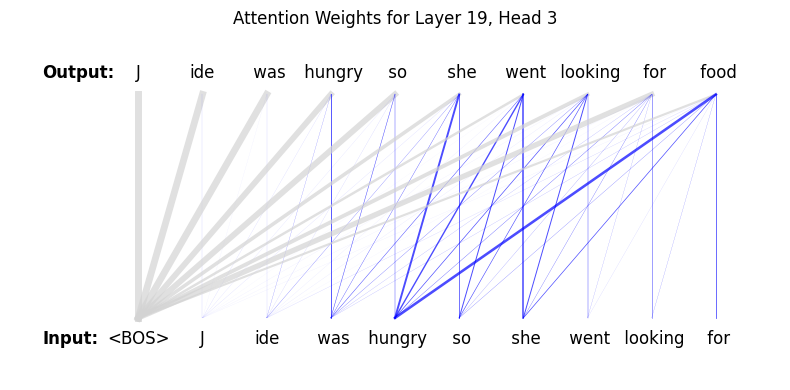

In [20]:
# @title Visualize attention weights (your implementation)
layer = 19  # @param {type:"slider", min: 0, max: 25}
head = 3  # @param {type:"slider", min: 0, max: 3}

prompt = "Jide was hungry so she went looking for"  # @param {type: 'string'}
# @markdown Check the following box to display the attention weights for all tokens, not just for the generated one:
show_all_weights = True  # @param {type:"boolean", label: "sfdsf"}

model_name = "Gemma-1B"

if prompt != previous_prompt2:
    (
        output_text2,
        next_token_logits2,
        tokenizer,
        attention_weights2,
        attention_mask2,
        qkv_dict2,
    ) = generation.prompt_attention_transformer_model(
        prompt, model, sampling_mode="greedy"
    )
    tokens2 = [tokenizer.tokens[t] for t in tokenizer.encode(output_text2)]
    previous_prompt2 = prompt

print(f"Generated text: {output_text2}")

attn_out, attn_weights = compute_attention(qkv_dict2, layer)

visualizations.visualize_attention(
    tokens2,
    attn_weights,
    layer,
    head=head,
    min_line_thickness=0,
    max_line_thickness=5,
    show_all_weights=show_all_weights,
)

### Efficiently computing the attention weights

The two visualizations in this lab show the attention weights for all tokens. As you have seen in this lab, the $Q$, $K$, and $V$ projection matrices contain the projections for all tokens and for all heads. Therefore, your computations automatically compute the attention weights and outputs for all tokens and heads. This allows for a high level of parallelization and makes transformer models very well-suited for efficiently training them on large quantities of data.

## Summary

In this lab, you implemented the **masked multi-head attention mechanism**, which is the core mechanism of any transformer model. You used the `jnp.tri` method for constructing the attention mask and then combined the query, key, and value matrices for all heads to 3-dimensional tensors. Finally, you computed the attention weights for all heads and used them to compute the output of the attention mechanism. This provides you with contextual embeddings from which you can predict the next token for a prompt.







## Solutions

The following cells provide reference solutions to the coding activities in this notebook. If you really get stuck after trying to solve the activities yourself, you may want to consult these solutions.

It is recommended that you *only* look at the solutions after you have tried to solve the activities *multiple times*. The best way to learn challenging concepts in computer science and artificial intelligence is to debug your code piece-by-piece until it works, rather than copying existing solutions.


If you feel stuck, you may want to first try to debug your code. For example, by adding additional print statements to see what your code is doing at every step. This will provide you with a much deeper understanding of the code and the materials. It will also provide you with practice on how to solve challenging coding problems beyond this course.


To view the solutions for an activity, click on the arrow to the left of the activity name. If you consult the solutions, do not copy and paste them into the cells above. Instead, look at them, and type them manually into the cell. This will help you understand where you went wrong.


### Coding Activity 1

In [ ]:
def compute_attention_mask(num_tokens: int) -> jax.Array:
    """Computes the attention mask for an input of length `num_tokens`.

    Args:
      num_tokens: Number of tokens in the input.

    Returns:
      attention_mask: A diagonal matrix indicating which attention logit should
        be masked. Shape: (num_tokens, num_tokens).
    """

    attention_mask = jnp.tri(num_tokens) # Shape: (num_tokens, num_tokens).

    return attention_mask


### Coding Activity 2

In [ ]:
def stack_matrices(
    qkv_dict: dict[str, dict[str, jax.Array]], layer: int
) -> tuple[jax.Array, jax.Array, jax.Array]:
    """Retrieves the list of query, key, and value matrices for each head and
        stacks them into a multi-dimensional tensor.

    Args:
      qkv_dict: A dictionary containing the raw query, key, and value
        projections for all layers. The keys are strings identifying the layers
        and matrix types, and values are the corresponding JAX arrays.
      layer: The specific layer for which to compute the attention weights.

    Returns:
      query_proj: Query projection tensor.
        Shape: (num_heads, num_tokens, dim_k).
      key_proj: Key projection tensor. Shape: (num_heads, num_tokens, dim_k).
      value_proj: Value projection tensor.
        Shape: (num_heads, num_tokens, dim_v).
    """

    # Passing `head=None` results in `get_qkv_matrices` returning lists of
    # `num_heads` projection matrices rather than just an individual projection
    # matrices.
    (
        query_proj_list,
        key_proj_list,
        value_proj_list
    ) = attention.get_qkv_matrices(
        qkv_dict, layer, head=None
    )

    # Stack the query, key, and value projection matrices here:
    # Shape: (num_heads, num_tokens, dim_k).
    query_proj = jnp.stack(query_proj_list, axis=0)
    # Shape: (num_heads, num_tokens, dim_k).
    key_proj = jnp.stack(key_proj_list, axis=0)
    # Shape: (num_heads, num_tokens, dim_v).
    value_proj = jnp.stack(value_proj_list, axis=0)

    return query_proj, key_proj, value_proj

### Coding Activity 3

In [ ]:
def compute_raw_logits(query_proj: jax.Array, key_proj: jax.Array) -> jax.Array:
    """Computes the raw logits from the query and key projection tensors, before
    applying the attention mask.

    Args:
      query_proj: The query projection tensor.
        Shape: (num_heads, num_tokens, dim_k).
      key_proj: The key projection tensor.
        Shape: (num_heads, num_tokens, dim_k).

    Returns:
      logits: The raw logits. Shape: (num_heads, num_tokens, num_tokens).
    """

    # Transpose the last two dimensions of the key matrix for matrix
    # multiplication. The shape changes from (heads, num_tokens, dim_k) to
    # (num_heads, dim_k, num_tokens).
    key_transposed = jnp.transpose(key_proj, (0, 2, 1))

    _, _, dim_k = key_proj.shape
    # Shape: (num_heads, num_tokens, num_tokens).
    logits = query_proj @ key_transposed / jnp.sqrt(dim_k)

    return logits

### Coding Activity 4

In [ ]:
def apply_attention_mask(logits_raw: jax.Array) -> jax.Array:
    """Computes the attention mask (using `compute_attention_mask`) and
    applies it to the logits.

    Args:
      logits_raw: Raw logits. Shape: (num_heads, num_tokens, num_tokens).

    Returns:
      Masked logits. Shape: (num_heads, num_tokens, num_tokens).
    """

    _, num_tokens, _ = logits_raw.shape

    # Shape: (num_heads, num_tokens, num_tokens).
    attention_mask = compute_attention_mask(num_tokens)
    # Shape: (num_heads, num_tokens, num_tokens).
    logits_masked = jnp.where(attention_mask, logits_raw, K_MASK)

    return logits_masked

### Coding Activity 5

In [ ]:
def compute_attention_weights(logits_masked: jax.Array) -> jax.Array:
    """Computes the attention weighs `alpha` from the masked logits by applying
    the SoftMax function.

    Args:
      logits_masked: Masked logits computed in previous steps.
        Shape: (num_heads, num_tokens, num_tokens).

    Returns:
      alpha: The attention weights. Shape: (num_heads, num_tokens, num_tokens).
    """

    # Apply the SoftMax.
    # Shape: (num_heads, num_tokens, num_tokens).
    alpha = jax.nn.softmax(logits_masked)

    return alpha

### Coding Activity 6

In [ ]:
def compute_attention_output(
    alpha: jax.Array, value_proj: jax.Array
) -> jax.Array:
    """Computes the output of the attention mechanism by computing the weighted
    sum of the embeddings in `value_proj`, using the attention weights `alpha`.

    Args:
      alpha: Attention weights. Shape: (num_heads, num_tokens, num_tokens).
      value_proj: Tensor with value projections.
        Shape: (num_heads, num_tokens, dim_v).

    Returns:
      Y: output of the attention mechanism.
        Shape: (num_heads, num_tokens, dim_v).
    """

    Y = alpha @ value_proj # Shape: (num_heads, num_tokens, dim_v).

    return Y